# 🤖 Multilayer Perceptron

Este Jupyter Notebook implementa una MLP para detectar patrones en una matriz 10x10.
Se genera un dataset para luego entrenar el modelo y validarlo.
Se evalúa la precisión para reiterar sobre el modelo con el objetivo de mejorar su eficacia.
Finalmente se exporta el modelo para ser utilizado en la aplicación web.


## 📋 Situación

En una matriz 10x10 se debe poder detectar las letras `b`, `d`, `f` que se corresponden a los siguientes patrones:

![Patrones que el MLP deberá reconocer](assets/patterns.png)

Se definen en Python los patrones 'b', 'd', y 'f'.
Ante un dato nuevo, el MLP debe ser capaz de clasificar el contenido de la matriz en uno de los tres patrones.


In [1]:
import pandas as pd
import numpy as np
from typing import Literal, Dict
import matplotlib.pyplot as plt

# Extend maximum width when printing DataFrames so they fit in just one line
pd.options.display.width = 100

# Set seed for reproducibility
SEED = 42
RNG = np.random.default_rng(SEED)

# fmt: off
# Define the 10x10 patterns for 'b', 'd', and 'f' as a 1D array
PATTERNS = {
    "b": np.array(
           [
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
            0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
            0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
            0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
            0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
            0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
            0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
            0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        ],
        dtype=np.uint8,
    ),
    "d": np.array(
        [
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
            0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
            0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
            0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
            0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
            0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
            0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
            0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        ],
        dtype=np.uint8,
    ),
    "f": np.array(
        [
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
            0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
            0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
            0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
            0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
            0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
            0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
            0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        ],
        dtype=np.uint8,
    ),
}
# fmt: on

## 🗃️ Generación de Datasets

Los datasets deben ser representativos a la hora de definir la distribución de los ejemplos de entrenamiento.
Conviene generar el conjunto de datos de manera procedural.
Se crea una función `generate_sample` que crea un ejemplo de un patrón dado con una distorsión entre 0 y 0.3.

La distorsión alterna píxeles seleccionados al azar de entre los 100 píxeles de la matriz, transformando ceros en unos y viceversa.
Una distorsión (_noise_) $n$ alterna $\frac{n * 100}{2}$ píxeles, de manera que una distorsión del $100\%$ alterna el valor de $50$ píxeles y alcanza la entropía máxima.


In [2]:
def generate_sample(pattern: Literal["b", "d", "f"], noise: float = 0.0) -> np.ndarray:
    """
    Generates a 1D array based on a given pattern letter ('b', 'd', or 'f'), with optional noise.
    A given noise (between 0 and 1) flips `noise * 100 / 2` pixels, such that a noise
    of 1 flips half the matrix (maximal entropy).

    Args:
        pattern: One of 'b', 'd', or 'f'.
        noise: Proportion of pixels to flip. A noise of 30% will flip 15 out of 100 pixels.
    Returns:
        A numpy 1D array representing the 10x10 matrix with the pattern and noise applied.
    """
    sample = PATTERNS[pattern].copy()
    num_pixels = sample.size
    num_noisy = int(noise * num_pixels / 2)

    if num_noisy > 0:
        # Choose random indices to flip
        indices = RNG.choice(num_pixels, num_noisy, replace=False)
        # Flip the selected pixels (0 becomes 1, 1 becomes 0)
        sample[indices] = 1 - sample[indices]

    return sample


def bold(str: str) -> str:
    """Returns the provided string wrapped in ANSI codes for bold text."""
    return f"\033[1m{str}\033[0m"


def print_sample(sample: np.ndarray):
    """Pretty-prints the provided 1D array as a 10x10 matrix."""
    GREEN = "\033[92m"
    RESET = "\033[0m"
    for i in range(10):
        row = sample[i * 10 : (i + 1) * 10]
        print(" ".join([bold(f"{GREEN}1{RESET}") if val else "0" for val in row]))


print("A 'b' sample with zero noise:")
print_sample(generate_sample("d", 0.00))
print()
print("A 'b' sample with 30% noise, meaning 15 cells have been randomly flipped:")
print_sample(generate_sample("d", 0.30))

A 'b' sample with zero noise:
0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 1 0 0
0 0 0 0 0 0 0 1 0 0
0 0 0 0 0 0 0 1 0 0
0 0 0 1 1 1 1 1 0 0
0 0 1 0 0 0 0 1 0 0
0 0 1 0 0 0 0 1 0 0
0 0 1 0 0 0 0 1 0 0
0 0 0 1 1 1 1 1 0 0
0 0 0 0 0 0 0 0 0 0

A 'b' sample with 30% noise, meaning 15 cells have been randomly flipped:
0 0 0 0 0 0 0 1 1 0
0 0 0 0 0 0 0 1 1 0
0 0 0 0 0 0 0 1 0 0
0 0 0 0 0 0 0 1 1 1
0 0 0 1 1 1 1 1 0 0
1 0 1 0 0 0 0 0 0 0
0 0 1 0 1 0 0 0 0 0
0 1 0 0 0 1 0 1 1 0
0 0 0 1 1 1 1 1 0 0
0 1 0 0 1 0 0 0 0 0


Luego se generan 3 datasets que contengan 100, 500 y 1000 ejemplos. 
El 10% son patrones sin distorsionar y el resto presentan una distorsión del 1% al 30%.
Se usa una **distribución uniforme** para ubicar el 90% de ejemplos en el rango de distorsión entre 0.01 y 0.30.

Cada dataset es un `pd.DataFrame` de `pandas` que contiene columnas del `0` al `99` (una por cada celda de la matriz) y una columna final `class` que indica la clase del patrón ('b', 'd' o 'f').


In [3]:
def generate_dataset(n_samples: int) -> pd.DataFrame:
    """
    Generates a dataset of pattern samples.
    The 90% of samples will have noise between 0.01 and 0.30.

    Args:
        n_samples: Number of samples to generate.
    Returns:
        A dataframe with 100 columns for the pattern and 1 column 'class' for the pattern class.
    """
    columns = [str(i) for i in range(100)] + ["class"]
    df = pd.DataFrame(0, index=np.arange(n_samples), columns=columns)
    df = df.astype({"class": "str"})

    for i in range(n_samples):
        # 10% without distortion, 90% with distortion between 1% and 30%
        if i < int(0.1 * n_samples):
            noise = 0.0
        else:
            noise = RNG.uniform(0.01, 0.30)

        # Pick a pattern at random
        pattern = RNG.choice(list(PATTERNS.keys()))

        sample = generate_sample(pattern, noise).flatten()
        df.iloc[i, :100] = sample
        df.loc[i, "class"] = pattern

    return df


DATASET_SIZES = [100, 500, 1000]
original_datasets = [generate_dataset(size) for size in DATASET_SIZES]

print("Dataset de 1000 ejemplos:")
print(original_datasets[2])

Dataset de 1000 ejemplos:
     0  1  2  3  4  5  6  7  8  9  ...  91  92  93  94  95  96  97  98  99  class
0    0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0      f
1    0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0      b
2    0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0      d
3    0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0      f
4    0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0      b
..  .. .. .. .. .. .. .. .. .. ..  ...  ..  ..  ..  ..  ..  ..  ..  ..  ..    ...
995  1  1  0  0  0  0  0  0  1  0  ...   0   0   0   0   1   0   0   0   0      f
996  0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0      b
997  0  0  0  0  0  0  0  0  0  1  ...   0   0   0   0   0   1   0   0   0      f
998  0  0  0  0  1  0  1  0  0  0  ...   0   1   0   0   0   0   0   0   1      f
999  0  0  0  0  1  0  0  0  1  0  ...   0   0   0   0   0   0   0   0  

Por cada dataset se construyen tres conjuntos de validación con 10%, 20% y 30% de los ejemplos, implicando conjuntos de entrenamiento del 90%, 80% y 70%.
Eso da un total de 9 pares de datasets:

| Dataset | Cantidad de Ejemplos | % Entrenamiento | % Validación |
|----|--------------------|-----------------|-------------|
|  1 | 100                | 90%             | 10%         |
|  2 | 100                | 80%             | 20%         |
|  3 | 100                | 70%             | 30%         |
|  4 | 500                | 90%             | 10%         |
|  5 | 500                | 80%             | 20%         |
|  6 | 500                | 70%             | 30%         |
|  7 | 1000               | 90%             | 10%         |
|  8 | 1000               | 80%             | 20%         |
|  9 | 1000               | 70%             | 30%         |

In [4]:
def split_dataset(
    df: pd.DataFrame, validation_ratio: float
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Splits the dataset into training and validation sets.

    Args:
        df: The dataset to split.
        validation_ratio: Proportion of the dataset to include in the validation set.
    Returns:
        tuple: (training_df, validation_df).
    """
    shuffled_df = df.sample(frac=1, random_state=SEED).reset_index(drop=True)
    validation_size = int(len(df) * validation_ratio)
    validation_df = shuffled_df.iloc[:validation_size].reset_index(drop=True)
    training_df = shuffled_df.iloc[validation_size:].reset_index(drop=True)
    return training_df, validation_df


def get_dataset_name(n_samples: int, validation_ratio: float):
    """Returns dataset name for a given number of samples and validation ratio."""
    return f"{n_samples}_samples:val_{int(validation_ratio * 100)}%"


VALIDATION_RATIOS = [0.1, 0.2, 0.3]

# Store all datasets in one dictionary
datasets = {}
for df in original_datasets:
    for validation_ratio in VALIDATION_RATIOS:
        training, validation = split_dataset(df, validation_ratio)
        n_samples = df.shape[0]
        key = get_dataset_name(n_samples, validation_ratio)
        datasets[key] = (training, validation)

## 🧠 Implementación del Modelo

Se debe implementar el algoritmo MLP que permita, dado un dataset, parametrizar la cantidad de capas, neuronas y funciones de activación con los que se entrenará la red neuronal.

Requerimientos para la arquitectura del modelo:

- 1 o 2 capas ocultas.
- De 5 a 10 neuronas por capa.
- Funciones de activación: lineal y sigmoidal.
- Coeficiente de aprendizaje entre 0 y 1.
- Término momento entre 0 y 1.

Se estudia el algoritmo utilizando de referencia la bibliografía recomendada por la cátedra [disponible en el campus virtual](https://frre.cvg.utn.edu.ar/pluginfile.php/105673/mod_label/intro/Perceprtr%C3%B3n-MLP.pdf):

- Hilera, J. R. Martinez, V. J. (2000) Redes Neuronales Artificiales. Fundamentos, modelos y aplicaciones. Alfaomega.

También se consulta material complementario para resolver dudas durante la implementación:

- Prince, S. J. D. (2023). Understanding deep learning. The MIT Press. [http://udlbook.com](http://udlbook.com).

### Arquitectura

La arquitectura de esta red neuronal feedforward (MLP) consiste en:

- **Capa de entrada:** 100 neuronas, una por cada celda de la matriz.
- **Capa oculta 1:** 10 neuronas.
- **Capa oculta 2:** 5 neuronas.
- **Capa de salida:** 3 neuronas, una para la clasificación de cada patrón 'b', 'd', 'f'.

Próximamente los hiperparámetros serán parametrizables, pero actualmente se utiliza esta arquitectura como base. 
Los parámetros son inicializados mediante la técnica de Xavier Glorot, y el entrenamiento del MLP consiste en ajustar estos parámetros hasta lograr una pérdida (_loss_) menor a cierta tolerancia.

![Diagrama de la arquitectura del MLP](assets/architecture.png)

Esta red neuronal es una función $f[X, \phi] = Y$ que clasifica el contenido de una matriz 10x10 en uno de tres patrones.
El contenido de la matriz 10x10 se representa como el vector de entrada $X = [x_0, x_1, \dots, x_{99}]^T$.
El vector de salida $Y = [y_b, y_d, y_f]^T$ contiene la predicción del modelo para cada patrón.
El conjunto de parámetros $\phi = \set{B_k, W_k}_{k=0}^K$ del modelo contiene:

- El vector de _biases_ $B_k$ que contribuyen a la capa $k+1$. Es de tamaño $D_{k+1}$.
- Los pesos (_weights_) $W_k$ aplicados a la capa $k$ y que contribuyen a la capa $k+1$. Es de tamaño $D_{k+1} \times D_k$.

La red neuronal se puede representar utilizando notación matricial:

$$
\begin{aligned}
X &= [x_1, x_2, \dots, x_{100}]^T \\
H_1 &= a \left[ B_{1} + W_{1} X \right] \\
H_2 &= a \left[ B_{2} + W_{2} H_1 \right] \\
Y &= B_3 + W_{3} H_2 \\
\end{aligned}
$$

donde $a[\bullet]$ es una función que aplica la función de activación por separado a cada elemento de su vector de entrada.

Esa notación se puede expandir de la siguiente manera (Prince, 2023, p. 48):

$$\begin{aligned}
H_1
&=
\begin{bmatrix}
h_1 \\
h_2 \\
\vdots \\
h_{10}
\end{bmatrix}
= 
a
\left[
\begin{bmatrix}
b_{1} \\
b_{2} \\
\vdots \\
b_{10}
\end{bmatrix}
+
\begin{bmatrix}
w_{11} & w_{12} & \dots & w_{1\ 100} \\
w_{21} & w_{22} & \dots & w_{2\ 100} \\
\vdots & \vdots & \ddots & \vdots \\
w_{10 \ 1} & w_{10\ 2} & \dots & w_{10\ 100} \\
\end{bmatrix}
\begin{bmatrix}
x_{1} \\
x_{2} \\
\vdots \\
x_{100}
\end{bmatrix}
\right]  \\

H_2
&=
\begin{bmatrix}
h'_1 \\
h'_2 \\
\vdots \\
h'_5
\end{bmatrix}
= 
a
\left[
\begin{bmatrix}
b'_{1} \\
b'_{2} \\
\vdots \\
b'_{5}
\end{bmatrix}
+
\begin{bmatrix}
w'_{11} & w'_{12} & \dots & w'_{1\ 10} \\
w'_{21} & w'_{22} & \dots & w'_{2\ 10} \\
\vdots & \vdots & \ddots & \vdots \\
w'_{51} & w'_{52} & \dots & w'_{5\ 10} \\
\end{bmatrix}
\begin{bmatrix}
h_{1} \\
h_{2} \\
\vdots \\
h_{10}
\end{bmatrix}
\right]  \\

Y
&=
\begin{bmatrix}
y_b \\
y_d \\
y_f
\end{bmatrix}
= 
\begin{bmatrix}
b''_{1} \\
b''_{2} \\
b''_{3}
\end{bmatrix}
+
\begin{bmatrix}
w''_{11} & w''_{12} & \dots & w''_{14} \\
w''_{21} & w''_{22} & \dots & w''_{24} \\
w''_{31} & w''_{32} & \dots & w''_{34} \\
\end{bmatrix}
\begin{bmatrix}
h'_{1} \\
h'_{2} \\
\vdots \\
h'_{5}
\end{bmatrix} \\
\end{aligned}
$$

Por ejemplo, la activación de la segunda neurona de la primera capa oculta se calcula como $h_1 = a[b_1 + w_{21}x_0 + \dots + w_{2\ 100}x_{100}]$.

A diferencia de Prince, Hilera & Martinez sí agregan una función de activación posterior a la capa de salida del MLP.
Para mantener este trabajo alineado con la bibliografía de la cátedra, se prioriza seguir la implementación de Hilera & Martinez.

### Funciones de Activación

Si bien existen múltiples funciones de activación, este trabajo práctico requiere dos en particular:

- Lineal.
- Sigmoidal.

![Funciones de activación](assets/activation_functions.png)


### Regla de Aprendizaje

Se debe elegir la regla de aprendizaje o _loss function_ a utilizar.
Hilera & Martinez (p. 119) presentan la regla _Least Mean Squared_ o _regla delta_:

$$
\epsilon_k^2 = \frac{1}{2L} \sum_{k=1}^L (d_k - s_k)^2
$$


mientras que Prince (p. 62) presenta una función _Least Squares_ similar que omite el coeficiente constante:

$$
L[\phi] = \sum_{i=1}^I (y_i - f[X_i, \phi])^2
$$

Ambas consisten en comparar la salida obtenida contra la deseada para obtener el costo o pérdida.
El costo se debería reducir en cada iteración del entrenamiento del MLP a medida que se ajustan los parámetros.


### Momento

El _momento_ es una modificación al algoritmo _backpropagation_ del gradiente descendiente para suavizar el progreso del algoritmo y evitar oscilaciones.
Matemáticamente es un coeficiente $\beta$ que se agrega para considerar el valor de un parámetro en la iteración anterior al momento de calcular su nuevo valor en la iteración siguiente.

Hilera & Martinez (p. 135) lo presentan como:

$$
\begin{aligned}
w_{ji} (t+1) &= w_{ji}(t) + \alpha \ \delta_{pj}y_{pi} + \underbrace {\beta (w_{ji}(t) - w_{ji} (t-1))}_\text{Término momento} \\
\Delta w_{ji} (t+1) &= \alpha \ \delta_{pj}y_{pi} + \beta \ \Delta w_{ji} (t) \\
\end{aligned}
$$

mientras que Prince (p. 86) lo presenta como:

$$
\begin{aligned}
\mathbf{m}_{t+1} &\leftarrow \beta \cdot \mathbf{m}_t 
  + (1 - \beta) \sum_{i \in \mathcal{B}_t} 
  \frac{\partial \ell_i[\boldsymbol{\phi}_t]}{\partial \boldsymbol{\phi}} \\[6pt]
\boldsymbol{\phi}_{t+1} &\leftarrow 
  \boldsymbol{\phi}_t - \alpha \cdot \mathbf{m}_{t+1}
\end{aligned}
$$

In [5]:
class MLP:
    """Multilayer Perceptron for pattern recognition."""

    def __init__(
        self,
        activation_type: Literal["sigmoid", "linear"] = "sigmoid",
        learning_rate: float = 0.1,
        momentum: float = 0.1,
    ):
        """
        Initialize the MLP with specified hyperparameters.

        Args:
            activation_type: Activation function type ("sigmoid" or "linear")
            learning_rate: Learning rate for gradient descent
            momentum: Momentum coefficient for parameter updates
        """
        self.activation_type = activation_type
        self.learning_rate = learning_rate
        self.momentum = momentum

        self.params = self.initialize_parameters()

    def initialize_parameters(self) -> Dict[str, np.ndarray]:
        """
        Initialize weights and biases using Xavier initialization, where each
        parameter will be drawn from a normal distribution with mean of `0` and
        a standard deviation of `sqrt(2 / (input_layer_size + output_layer_size))`
        to help prevent vanishing or exploding gradients.
        """
        # Initialize layer 1 parameters (input -> hidden1)
        std1 = np.sqrt(2.0 / (100 + 10))
        W1 = RNG.normal(0, std1, (10, 100))
        b1 = np.zeros(10)

        # Initialize layer 2 parameters (hidden1 -> hidden2)
        std2 = np.sqrt(2.0 / (10 + 5))
        W2 = RNG.normal(0, std2, (5, 10))
        b2 = np.zeros(5)

        # Initialize output layer parameters (hidden2 -> output)
        std3 = np.sqrt(2.0 / (5 + 3))
        W3 = RNG.normal(0, std3, (3, 5))
        b3 = np.zeros(3)

        return {
            "W1": W1,
            "b1": b1,
            "W2": W2,
            "b2": b2,
            "W3": W3,
            "b3": b3,
            "delta_W1": np.zeros_like(W1),
            "delta_b1": np.zeros_like(b1),
            "delta_W2": np.zeros_like(W2),
            "delta_b2": np.zeros_like(b2),
            "delta_W3": np.zeros_like(W3),
            "delta_b3": np.zeros_like(b3),
        }

    def get_activation_function(self):
        """Return the activation function based on activation type."""
        if self.activation_type == "sigmoid":
            return lambda x: 1 / (1 + np.exp(-x))
        elif self.activation_type == "linear":
            return lambda x: x

    def get_activation_derivative(self):
        """Return the derivative of the activation function based on activation type."""
        if self.activation_type == "sigmoid":
            return lambda x: 1 / (1 + np.exp(-x)) * (1 - 1 / (1 + np.exp(-x)))
        elif self.activation_type == "linear":
            return lambda x: np.ones_like(x)

    def feedforward(self, X: np.ndarray) -> np.ndarray:
        """
        Perform a feedforward pass through the network.
        See: Prince, 2023 (page 103) or Hilera & Martinez, 2000 (pages 138-139).

        Args:
            X: Input pattern (100 values).
        Returns:
            Array with all neuron activations at each layer [X, h1, h2, y].
        """
        a = self.get_activation_function()

        # Forward pass from input layer to hidden layer 1
        h1 = a(self.params["b1"] + np.dot(self.params["W1"], X))

        # Forward pass from hidden layer 1 to hidden layer 2
        h2 = a(self.params["b2"] + np.dot(self.params["W2"], h1))

        # Forward pass from hidden layer 2 to output layer
        y = a(self.params["b3"] + np.dot(self.params["W3"], h2))

        return [X, h1, h2, y]

    def backpropagation(self, X: np.ndarray, d: np.ndarray, activations: list) -> dict:
        """
        Backpropagation. See: Hilera & Martinez, 2000 (pages 133-142).

        Args:
            X: Input pattern (100 values).
            d: Target output (3 values).
            activations: Neuron activations from forward pass [X, h1, h2, y_pred].
        Returns:
            Dictionary with updated parameters.
        """
        _, h1, h2, y_pred = activations
        a_derived = self.get_activation_derivative()

        # Output layer (see page 134-135)
        delta3 = (d - y_pred) * a_derived(y_pred)

        delta_W3 = (
            self.learning_rate * np.outer(delta3, h2)
            + self.momentum * self.params["delta_W3"]
        )
        delta_b3 = self.learning_rate * delta3 + self.momentum * self.params["delta_b3"]

        # Hidden layer 2 (see page 135)
        delta2 = np.dot(self.params["W3"].T, delta3) * a_derived(h2)

        delta_W2 = (
            self.learning_rate * np.outer(delta2, h1)
            + self.momentum * self.params["delta_W2"]
        )
        delta_b2 = self.learning_rate * delta2 + self.momentum * self.params["delta_b2"]

        # Hidden layer 1 (see page 135)
        delta1 = np.dot(self.params["W2"].T, delta2) * a_derived(h1)

        delta_W1 = (
            self.learning_rate * np.outer(delta1, X)
            + self.momentum * self.params["delta_W1"]
        )
        delta_b1 = self.learning_rate * delta1 + self.momentum * self.params["delta_b1"]

        # Update parameters (see page 135)
        new_params = self.params.copy()
        new_params["W1"] += delta_W1
        new_params["b1"] += delta_b1
        new_params["W2"] += delta_W2
        new_params["b2"] += delta_b2
        new_params["W3"] += delta_W3
        new_params["b3"] += delta_b3

        # Update momentum terms (see page 135)
        new_params["delta_W1"] = delta_W1
        new_params["delta_b1"] = delta_b1
        new_params["delta_W2"] = delta_W2
        new_params["delta_b2"] = delta_b2
        new_params["delta_W3"] = delta_W3
        new_params["delta_b3"] = delta_b3

        return new_params

    def calculate_loss(self, d: np.ndarray, s: np.ndarray) -> float:
        """Compute least mean squared error loss. See: Hilera & Martinez, 2000 (page 119)."""
        return (1 / (2 * len(d))) * np.sum((d - s) ** 2)

    def classify(self, X: np.ndarray) -> str:
        """
        Classify the input pattern into a class.

        Args:
            X: Input pattern (100 values).
        Returns:
            "b", "d", or "f" according to the maximal output neuron.
        """
        y_pred = self.feedforward(X)[-1]
        idx = int(np.argmax(y_pred))
        classes = ["b", "d", "f"]
        return classes[idx]

    def train_dataset(
        self, train_data: pd.DataFrame, tolerance: float = 1e-5
    ) -> Dict[str, list]:
        """
        Train the MLP on a complete dataset using tolerance-based early stopping.

        Args:
            train_data: DataFrame with 100 feature columns and a 'class' column.
            tolerance: Minimum difference between losses to continue training.
        Returns:
            Dictionary with training history.
        """
        train_losses = []
        train_accuracies = []
        prev_avg_loss = float("inf")
        epoch = 0

        print(" " + "_" * 33 + " ")
        print(f"| {bold('Epoch')} | {bold('    Loss    ')} | {bold('Accuracy')} |")

        while True:
            epoch_loss = 0
            correct = 0

            for i in range(len(train_data)):
                # Get the sample and its labels
                sample = np.array(train_data.iloc[i, :100].values, dtype=np.float64)
                true_class = train_data.iloc[i, 100]
                d = np.array(
                    [1, 0, 0]
                    if true_class == "b"
                    else [0, 1, 0]
                    if true_class == "d"
                    else [0, 0, 1]
                )

                # Train on the given sample
                activations = self.feedforward(sample)
                self.params = self.backpropagation(sample, d, activations)
                y_pred = activations[-1]
                loss = self.calculate_loss(d, y_pred)
                epoch_loss += loss

                # Check if the prediction is correct
                predicted = self.classify(sample)
                if predicted == true_class:
                    correct += 1

            avg_loss = epoch_loss / len(train_data)
            accuracy = correct / len(train_data)

            train_losses.append(avg_loss)
            train_accuracies.append(accuracy)

            # Print progress
            if epoch % 25 == 0:
                print(f"| {epoch:5} | {avg_loss:12.10f} | {accuracy:8.6f} |")

            # Check for stop condition
            loss_change = abs(avg_loss - prev_avg_loss)
            if loss_change < tolerance:
                print(" " + "¯" * 33 + " ")
                print(
                    f"Stopping at epoch {epoch}: Loss change {loss_change} < tolerance={tolerance}"
                )
                break

            prev_avg_loss = avg_loss
            epoch += 1

        return {"train_losses": train_losses, "train_accuracies": train_accuracies}


print("Simple test with a dataset of just one sample:")
single_sample_df = generate_dataset(1)
sample = np.array(single_sample_df.iloc[0, :100].values, dtype=np.float64)
print_sample(sample)
mlp = MLP("sigmoid", 0.1, 0.1)
mlp.train_dataset(single_sample_df, tolerance=0.00001)
c = mlp.classify(sample)
print(f"Pattern classified into class {bold(c)}.")

Simple test with a dataset of just one sample:
0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 1 0 0
0 0 0 0 0 0 0 1 0 0
0 0 0 0 0 0 0 1 0 0
0 0 0 1 1 1 1 1 0 0
0 0 0 0 0 0 0 1 1 0
0 0 1 0 0 0 0 1 0 0
0 0 1 0 0 0 0 1 0 0
0 0 0 1 0 1 1 0 0 0
0 0 0 0 0 0 0 0 0 0
 _________________________________ 
| Epoch |     Loss     | Accuracy |
|     0 | 0.1498321450 | 0.000000 |
|    25 | 0.0581357083 | 1.000000 |
|    50 | 0.0232573598 | 1.000000 |
|    75 | 0.0111603269 | 1.000000 |
|   100 | 0.0062206173 | 1.000000 |
|   125 | 0.0038538246 | 1.000000 |
|   150 | 0.0025751451 | 1.000000 |
|   175 | 0.0018200026 | 1.000000 |
|   200 | 0.0013428240 | 1.000000 |
|   225 | 0.0010249270 | 1.000000 |
 ¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯ 
Stopping at epoch 229: Loss change 9.962390779239124e-06 < tolerance=1e-05
Pattern classified into class d.


## 🛠️ Entrenamiento

Una vez implementado el MLP con sus algoritmos de feedforward y backpropagation, se puede entrenar el modelo para ajustar los parámetros.
Se entrena un MLP por separado para cada uno de los 9 pares de datasets generados anteriormente.


In [7]:
results = []

for key in datasets:
    train_data, val_data = datasets[key]
    print(f"\n--- Dataset {key} ---")
    mlp = MLP("sigmoid", 0.1, 0.1)
    history = mlp.train_dataset(train_data, tolerance=0.000001)
    results.append(
        {
            "dataset_name": key,
            "epochs": range(len(history["train_losses"])),
            "train_losses": history["train_losses"],
            "train_accuracies": history["train_accuracies"],
        }
    )

print("All 9 MLPs trained.")


--- Dataset 100_samples:val_10% ---
 _________________________________ 
| Epoch |     Loss     | Accuracy |
|     0 | 0.1110465223 | 0.411111 |
|    25 | 0.0499985164 | 0.744444 |
|    50 | 0.0395924493 | 0.988889 |
|    75 | 0.0151133647 | 1.000000 |
|   100 | 0.0112773408 | 1.000000 |
|   125 | 0.0071390890 | 1.000000 |
|   150 | 0.0056344264 | 1.000000 |


/tmp/ipykernel_49838/2555063262.py:64: RuntimeWarning: overflow encountered in exp
  return lambda x: 1 / (1 + np.exp(-x))


|   175 | 0.0027513121 | 1.000000 |
|   200 | 0.0035503898 | 1.000000 |
|   225 | 0.0035069964 | 1.000000 |
|   250 | 0.0001118134 | 1.000000 |
|   275 | 0.0000810404 | 1.000000 |
|   300 | 0.0029725812 | 1.000000 |
 ¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯ 
Stopping at epoch 315: Loss change 1.4071778502071315e-07 < tolerance=1e-06

--- Dataset 100_samples:val_20% ---
 _________________________________ 
| Epoch |     Loss     | Accuracy |
|     0 | 0.1128422472 | 0.437500 |
|    25 | 0.0476836144 | 0.737500 |
|    50 | 0.0473038865 | 0.737500 |
|    75 | 0.0471462215 | 0.737500 |
|   100 | 0.0468138851 | 0.737500 |
|   125 | 0.0425918785 | 0.775000 |
|   150 | 0.0088461914 | 1.000000 |
|   175 | 0.0062422099 | 1.000000 |
 ¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯ 
Stopping at epoch 197: Loss change 3.9831899076563787e-07 < tolerance=1e-06

--- Dataset 100_samples:val_30% ---
 _________________________________ 
| Epoch |     Loss     | Accuracy |
|     0 | 0.1192050154 | 0.342857 |
|    25 | 0.045246

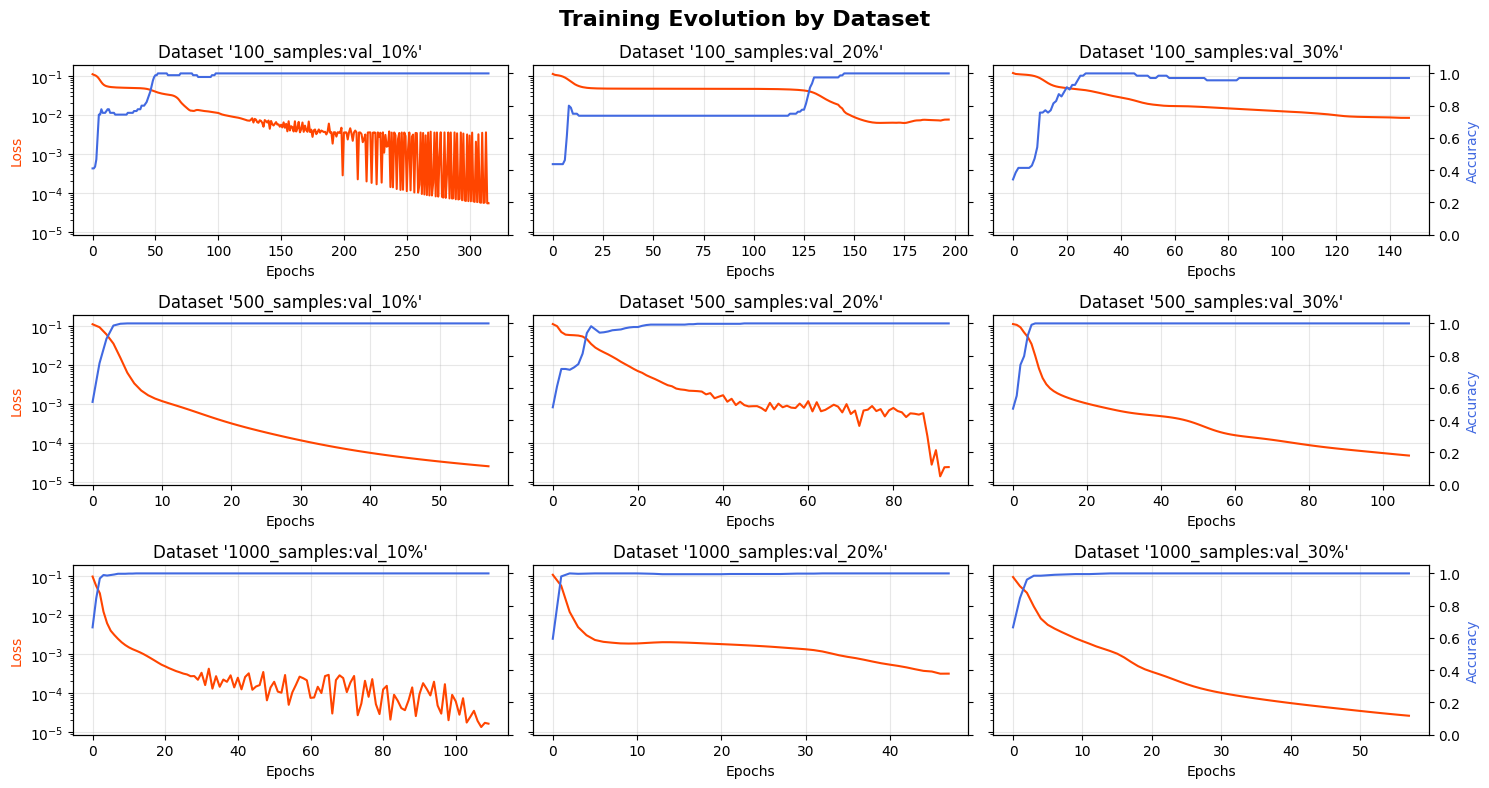

In [8]:
fig, axes = plt.subplots(3, 3, figsize=(15, 8), sharey=True)
fig.suptitle("Training Evolution by Dataset", fontsize=16, fontweight="bold")

for idx, res in enumerate(results):
    # Draw loss curve
    ax = axes[idx // 3, idx % 3]
    ax.plot(res["epochs"], res["train_losses"], color="orangered", label="Loss")
    ax.set_yscale("log")

    # Draw accuracy curve on the same plot with a different y-axis
    ax2 = ax.twinx()
    ax2.plot(
        res["epochs"], res["train_accuracies"], color="royalblue", label="Accuracy"
    )
    ax2.set_ylim(0, 1.05)

    ax.set_title(f"Dataset '{res['dataset_name']}'")
    ax.grid(True, alpha=0.3)
    ax.set_xlabel("Epochs")

    # Set loss label on first column
    if idx % 3 == 0:
        ax.set_ylabel("Loss", color="orangered")
    # Set accuracy label on third column
    if idx % 3 == 2:
        ax2.set_ylabel("Accuracy", color="royalblue")
    # Hide right y-axis tick labels for first and second columns
    if idx % 3 != 2:
        ax2.set_yticklabels([])

plt.tight_layout()
plt.show()